# TODO List:
- [X] Debug `conjcalc()` function (why does it run *outside* the for loop but not *inside*?)
- [ ] Run current code for all points and see how it looks....
- [ ] Implement AACGM calculations in parallel
- [ ] Compare output of AACGM and geopack for test points
- [ ] Map difference between AACGM and geopack results (e.g.: https://plotly.com/python/lines-on-maps/)
- [ ] Plot field line vector calculated by geopack
- [ ] Implement magnetic graticules (code from Frissell)
- [ ] Add "How to Use This Map" information to README
- [ ] Create list of icons for different station types

# Geomagnetic Conjugate Map
The purpose of this notebook is to gather relevant stations and mapping information for a geomagnetic conjugate map.

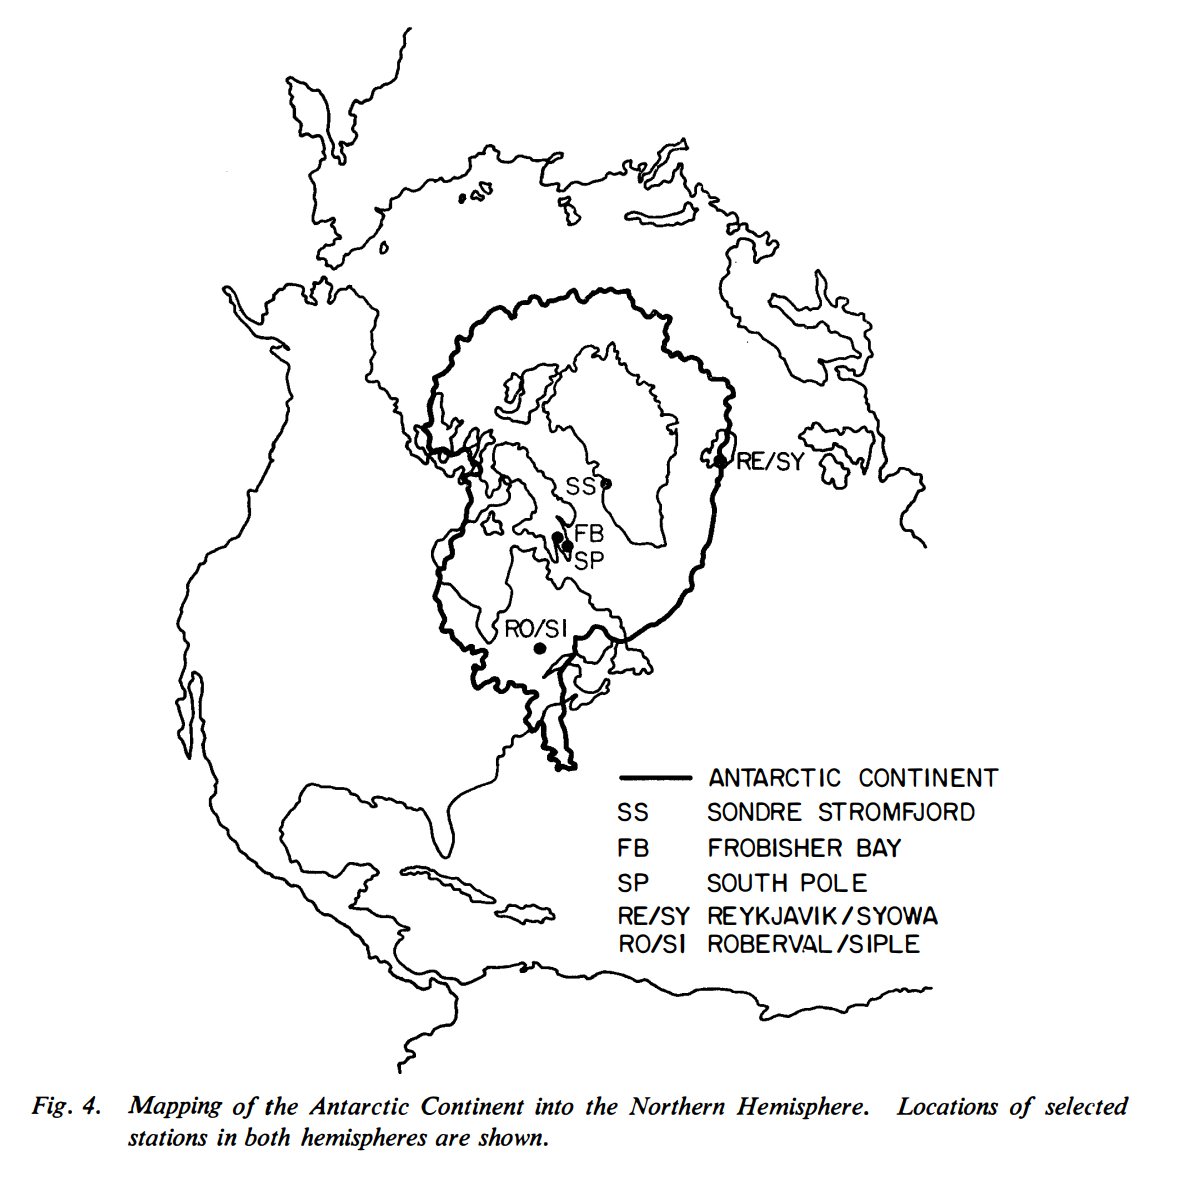

Papers on field line tracing: 
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008SW000391
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/jgra.50137

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import json
import ogr
import geopandas as gpd
import aacgmv2
import datetime as dt
import numpy as np


import pandas as pd
smag = __import__('supermag-api')          # SuperMAG python API
logon = 'kd8oxt'                              # SuperMAG ID

# # For pulling data from CDAweb:
# from ai import cdas
# import datetime
# from matplotlib import pyplot as plt

import gpxpy
import gpxpy.gpx

import geopandas

# converting from geographic to GSM
from geopack import geopack as gp 
from geopack import t89

Load IGRF coefficients ...


First, some geopack example code. Let's try doing this with geopack: 

- [x] Get the latitude and longitude for the location of interest (section of coastline, station, etc)
- [x] use the "geopack_sphcar" function to convert from spherical (lat, lon, r=1) to cartesian coordinates
- [x] "GEOPACK_RECALC" to initialize variables (might not be needed)
- [x] Convert from Cartesian geo to Cartesian GSM
- [x] use "trace2iono" to trace from the southern hemisphere location to the north (or vice versa) with the IGRF magnetic field model. This is the crucial piece that we'll probably need to spend some time talking about because there's a lot of knobs you can turn for the way the tracing is done
- [x] Convert that output back from cartesian GSM to Cartesian geo
 - [x] use "geopack_sphcar" again to go from cartesian back to lat/lons for plotting

In [2]:
def findconj(lat, lon, ut = dt.datetime(2013, 11, 3, 18, 0, 0).timestamp(), is_verbose = 0):
    
    # ut = dt.datetime(2013, 11, 3, 18, 0, 0).timestamp()    
    ps = gp.recalc(ut)
    if is_verbose: print('............................................Calculating conjugate point for ' + str(lat)  + ', '+ str(lon)  + ' at ' + str(ut) +  ': ')

    r, theta, phi = [1, 90-lat, lon] # r is Earth radii; theta is colatitude (i.e., in degrees from 0 (North Pole) to 360 (South Pole)); phi is longitude in degrees   

    theta, phi = np.deg2rad([theta, phi])
    if is_verbose: print('r, theta, phi: ')
    if is_verbose: print(r, theta, phi)
    xgeo, ygeo, zgeo = gp.sphcar(r, theta, phi, 1)
    if is_verbose: print('Cartesian output: ')
    if is_verbose: print(xgeo, ygeo, zgeo)
    if is_verbose: print('Sum of squares (should be 1):')
    if is_verbose: print(xgeo**2 + ygeo**2 + zgeo**2)
    if is_verbose: print('GSM coordinates: ')
    xgsm,ygsm,zgsm = gp.geogsm(xgeo,ygeo,zgeo, 1)
    if is_verbose: print(xgsm,ygsm,zgsm)
    if is_verbose: print('Sum of squares (should be 1):')
    if is_verbose: print(xgsm**2 + ygsm**2 + zgsm**2)

    # Now let's try running the field line trace: See help(gp.trace) for documentation.
    rlim, r0 = [1000, .9]

    # 

    foo= gp.trace(xgsm,ygsm,zgsm, dir=-1, rlim=rlim, r0=r0, parmod=2, exname='t89', inname='igrf')

    # if is_verbose: print(x1gsm,y1gsm,z1gsm)

    x1gsm,y1gsm,z1gsm = foo[0:3]
    if is_verbose: print('Traced GSM Coordinates, Cartesian: ')
    if is_verbose: print(x1gsm,y1gsm,z1gsm)
    if is_verbose: print(str(len(foo[4])) + ' points in traced vector.')
    if is_verbose: print('Sum of squares (should be 1):')
    if is_verbose: print(x1gsm**2 + y1gsm**2 + z1gsm**2)

    # geogsm
    x1geo, y1geo, z1geo = gp.geogsm(x1gsm,y1gsm,z1gsm,-1)
    if is_verbose: print('Geographic coordinates, Cartesian: ')
    if is_verbose: print(x1geo, y1geo, z1geo)
    if is_verbose: print('Sum of squares (should be 1):')
    if is_verbose: print(x1geo**2 + y1geo**2 + z1geo**2)

    # convert back to spherical
    if is_verbose: print('Geographic coordinates, spherical: ')
    [x1_r, x1_theta, x1_phi] = gp.sphcar(x1geo,y1geo,z1geo,-1)
    if is_verbose: print(x1_r, x1_theta, x1_phi)

    # back to lat/long:
    x1_theta, x1_phi = np.rad2deg([x1_theta, x1_phi])
    if is_verbose: print('Lat/lon of conjugate point: ')
    lat = 90-x1_theta
    lon = x1_phi
    if is_verbose: print(lat, lon)
    return lat, lon

ut = dt.datetime(2013, 11, 3, 18, 0, 0).timestamp() 
lat, lon = [-64, -64]

findconj(lat, lon, ut)

(43.47469794868233, 288.6892753330926)

In [3]:
def conjcalc(gdf, latname="GLAT", lonname="GLON", dtime = dt.datetime(2013, 11, 3)):
    # # Prallocate columns for magnetic coordinates:
    # gdf['XGSM'] = np.nan # GSM, Cartesian
    # gdf['YGSM'] = np.nan # GSM, Cartesian
    # gdf['ZGSM'] = np.nan # GSM, Cartesian
    # gdf['X1GSM'] = np.nan # conjugate GSM, Cartesian
    # gdf['Y1GSM'] = np.nan # conjugate GSM, Cartesian
    # gdf['Z1GSM'] = np.nan # conjugate GSM, Cartesian
    # gdf['X1GEO'] = np.nan # conjugate geographic, Cartesian
    # gdf['Y1GEO'] = np.nan # conjugate geographic, Cartesian
    # gdf['Z1GEO'] = np.nan # conjugate geographic, Cartesian
    # gdf['CLAT'] = np.nan # conjugate geographic, latitude
    # gdf['CLON'] = np.nan # conjugate geographic, longitude
    gdf['Hemisphere'] = np.nan
    gdf['PLAT'] = np.nan # latitude and longitude to plot
    gdf['PLON'] = np.nan # latitude and longitude to plot
    
    # gdf['GLAT'] = gdf['GLAT'].astype(float)
    # gdf['GLON'] = gdf['GLON'].astype(float)
    # gdf['GLON'] = gdf['GLON'].apply(lambda glon: glon - 360 if glon > 180 else glon) # unify: +/- 180 deg longitude format

    # Iterate over the DataFrame
    for index, row in gdf.iterrows():
        try:
            lat = row[latname]
            lon = row[lonname]
            if lon>180: lon = lon-360
            try:
                [clat, clon] = findconj(lat, lon, is_verbose = 0)
                gdf.loc[index, 'PLAT'],gdf.loc[index, 'PLON'] = [clat, clon]
            except Exception as e:
                print('Ran into a problem with ' + index)
                print(e)


            # Figure out what coordinates we ultimately want to plot:
            # if gdf.loc[index, 'GLAT']>0:
            if lat>0:
                print('Setting Northern hemisphere for GLAT of ' + str(lat) + ' on station ' + index)
                gdf.loc[index, 'Hemisphere'] = 'N'
                gdf.loc[index, 'PLAT'] = lat
                gdf.loc[index, 'PLON'] = lon

            else:
                print('Setting Southern hemisphere for GLAT of ' + str(lat) + ' on station ' + index)
                gdf.loc[index, 'Hemisphere'] = 'S'
                gdf.loc[index, 'PLAT'] = clat
                gdf.loc[index, 'PLON'] = clon
                
            
        except Exception as e:
            print('Ran into a problem with ' + str(index))
            print(e)
            continue

    return gdf


In [4]:
# stations = conjcalc(stations)

Here's a function to take in a dataframe and add columns for all stages of calculating conjugate points:

## Stations and Features
First, let's collect stations and features of interest into pandas dataframes. (Make sure to include dates of operation wherever possible - want to make sure that we have that information when creating historical maps later!)

I'm collecting station information here: https://docs.google.com/spreadsheets/d/1DYVxUyF0DDpw7SoCTTIANWcNzMouLW6NB8Slq00Icc8/edit?usp=sharing

In [5]:
import pandas as pd
stations = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
                   '1DYVxUyF0DDpw7SoCTTIANWcNzMouLW6NB8Slq00Icc8'+
                   # '/edit#gid=0'
                   # '0Ak1ecr7i0wotdGJmTURJRnZLYlV3M2daNTRubTdwTXc' +
                   '/export?gid=0&format=csv',
                   # Set first column as rownames in data frame
                   index_col=0,
                   # Parse column values to datetime
                   parse_dates=['Start', 'End']
                  )
stations["Source"] = "Manual"
stations.head()  # Same result as @TomAugspurger

ID       Category Network  Nation       Institution  GLAT  \
Name                                                                      
Nain         NAN  Magnetometers   MACCS     USA  Augsburg College  56.4   
Pangnirtung  PGG  Magnetometers   MACCS     USA  Augsburg College  66.1   
Clyde River  CRV  Magnetometers   MACCS     USA  Augsburg College  70.5   
Iqaluit      IQA  Magnetometers   MACCS  Canada  Augsburg College  63.8   
Cape Dorset  CDR  Magnetometers   MACCS     USA  Augsburg College  64.2   

              GLON Start End  Notes  \
Name                                  
Nain         298.3   NaT NaT    NaN   
Pangnirtung  294.2   NaT NaT    NaN   
Clyde River  291.4   NaT NaT    NaN   
Iqaluit      291.5   NaT NaT    NaN   
Cape Dorset  283.4   NaT NaT    NaN   

                                                     Data Link  Source  
Name                                                                    
Nain         http://space.augsburg.edu/maccs/availability.h...  Manual  
Pangnirtung  http://space.augsburg.edu/maccs/availability.h...  Manual  
Clyde River  http://space.augsburg.edu/maccs/availability.h...  Manual  
Iqaluit                                                    NaN  Manual  
Cape Dorset  http://space.augsburg.edu/maccs/availability.h...  Manual

### Marc Engebretson's wish list:

- [ ] *TODO*: Get each of these into a spreadsheet/dataframe and import them to this notebook accordingly.

- [ ] Figure 1 and Table 1 in the attached file “JGRA – 2022 – Engebretson…”  show stations used in one of my recent papers.  The table contains a full list of AAL-PIP stations in Antarctica but only a partial list of stations in the other arrays mentioned.  In Figure 1 the stations in one high latitude hemisphere are mapped to their magnetically conjugate region in the other hemisphere. 
- [ ] Greenland coastal arrays:  a web site with the full list of west coast and east coast stations is
https://www.space.dtu.dk/english/research/scientific_data_and_models/magnetic_ground_stations#list  
Only one of the stations on the Greenland Ice Cap is still operating. See tables in doi.org/10.1029/2022JA030580

- [ ] British Antarctic survey chain:  Coordinates are part of the station name, as in “M85-002 – 85.36° 2.06°” in Table 1 of the attached file “JGRA – 2022 – Engebretson…”.  The full list of stations is in the attached file ”Full Record – LPM…” https://www.bas.ac.uk/project/low-power-magnetometer-lpm-network/
- [ ] AUTUMNX array coordinates are in the attached file “Connors2016…..”  doi.org/10.1186/s40623-015-0354-4 See Figure 4 (yellow circles) and Table 1.  They are also available at https://autumn.athabascau.ca/TBS_autumnxquery2.php
- [X] MACCS array coordinates are in the attached file “MACCS array and…”  (see link below)
- [ ] CANMOS array geographic coordinates are listed here:  https://geomag.nrcan.gc.ca/obs/default-en.php

### Northern Hemisphere Stations
- [ ] AMISR - should be conjugate with McMurdo
- [X] MACCS network
- [ ] North American research institutions (CWRU, MIT, NJIT, VA Tech, DTU, and other universities who have space wx/have expressed interest)
- [ ] ISRs
- [ ] All-sky cameras
- [X] Full set of magnetometer networks from SuperMAG

Let's pull some more Northern hemisphere stations from the list of instruments in the Madrigal database, at http://cedar.openmadrigal.org/instMetadata. (It would be good form to use the `madrigalWeb` python package for this if we need more data.)

In [6]:
# madrigal = pd.read_csv("madrigal.csv")
madrigal = pd.read_html("http://cedar.openmadrigal.org/instMetadata")[0]
madrigal = madrigal.rename(columns={"3-letter mnemonic": "ID", "Latitude": "GLAT", "Longitude (-180-180)":"GLON"})
madrigal = madrigal.set_index("Name")
madrigal["Source"] = "Madrigal"

# add to stations list:
stations = pd.concat([stations, madrigal], ignore_index=False)

Downloading SUPERMAG's list of stations from https://supermag.jhuapl.edu/mag/?fidelity=low&tab=stationinfo&start=2001-01-01T00%3A00%3A00.000Z&interval=23%3A59#:

(I've edited the operators column of the spreadsheet to make it digestible to pandas...)

In [7]:
supermag = pd.read_csv("20230803-11-15-supermag-stations.csv", sep = ',') 

supermag = supermag.rename(columns={"STATION-NAME":"Name", "IAGA": "ID", "GEOLAT": "GLAT", "GEOLON":"GLON", "OP1":"Network"})
supermag = supermag.set_index("Name")
supermag["Category"] = "Magnetometers"
supermag["Source"] = "SuperMAG"

# add to stations list:
stations = pd.concat([stations, supermag], ignore_index=False)

stations

ID       Category  Network  Nation       Institution   GLAT  \
Name                                                                        
Nain         NAN  Magnetometers    MACCS     USA  Augsburg College   56.4   
Pangnirtung  PGG  Magnetometers    MACCS     USA  Augsburg College   66.1   
Clyde River  CRV  Magnetometers    MACCS     USA  Augsburg College   70.5   
Iqaluit      IQA  Magnetometers    MACCS  Canada  Augsburg College   63.8   
Cape Dorset  CDR  Magnetometers    MACCS     USA  Augsburg College   64.2   
...          ...            ...      ...     ...               ...    ...   
Bor          POD  Magnetometers  IZMIRAN     NaN               NaN  61.58   
Tormestorp   TOP  Magnetometers    IMAGE     NaN               NaN  56.09   
Augusta      R11  Magnetometers  MAGSTAR     NaN               NaN   44.3   
Grant        R12  Magnetometers  MAGSTAR     NaN               NaN   47.5   
Pawnee       R13  Magnetometers  MAGSTAR     NaN               NaN   40.2   

              GLON Start End  Notes  ... Altitude (km) Principal Investigator  \
Name                                 ...                                        
Nain         298.3   NaT NaT    NaN  ...           NaN                    NaN   
Pangnirtung  294.2   NaT NaT    NaN  ...           NaN                    NaN   
Clyde River  291.4   NaT NaT    NaN  ...           NaN                    NaN   
Iqaluit      291.5   NaT NaT    NaN  ...           NaN                    NaN   
Cape Dorset  283.4   NaT NaT    NaN  ...           NaN                    NaN   
...            ...   ...  ..    ...  ...           ...                    ...   
Bor          90.03   NaT NaT    NaN  ...           NaN                    NaN   
Tormestorp   13.18   NaT NaT    NaN  ...           NaN                    NaN   
Augusta      290.4   NaT NaT    NaN  ...           NaN                    NaN   
Grant        242.3   NaT NaT    NaN  ...           NaN                    NaN   
Pawnee       256.3   NaT NaT    NaN  ...           NaN                    NaN   

             PI Email AACGMLON AACGMLAT OPERATOR-NUM  OP2  OP3  Unnamed: 10  \
Name                                                                          
Nain              NaN      NaN      NaN          NaN  NaN  NaN          NaN   
Pangnirtung       NaN      NaN      NaN          NaN  NaN  NaN          NaN   
Clyde River       NaN      NaN      NaN          NaN  NaN  NaN          NaN   
Iqaluit           NaN      NaN      NaN          NaN  NaN  NaN          NaN   
Cape Dorset       NaN      NaN      NaN          NaN  NaN  NaN          NaN   
...               ...      ...      ...          ...  ...  ...          ...   
Bor               NaN   163.04    57.25          1.0  NaN  NaN          NaN   
Tormestorp        NaN    90.96    52.56          1.0  NaN  NaN          NaN   
Augusta           NaN     9.46    54.00          1.0  NaN  NaN          NaN   
Grant             NaN   -57.23    54.01          1.0  NaN  NaN          NaN   
Pawnee            NaN   -38.59    49.50          1.0  NaN  NaN          NaN   

            Unnamed: 11  
Name                     
Nain                NaN  
Pangnirtung         NaN  
Clyde River         NaN  
Iqaluit             NaN  
Cape Dorset         NaN  
...                 ...  
Bor                 NaN  
Tormestorp          NaN  
Augusta             NaN  
Grant               NaN  
Pawnee              NaN  

[909 rows x 23 columns]

Alternatively, we can pull data using the SuperMAG API:

### Antarctic Stations
- [x] AALPIP stations
- [x] Import COMNAP data - use https://github.com/PolarGeospatialCenter/comnap-antarctic-facilities/tree/master

In [8]:
url = "https://github.com/PolarGeospatialCenter/comnap-antarctic-facilities/raw/master/dist/COMNAP_Antarctic_Facilities_Master.xls"

comnap_df = pd.read_excel(url)

comnap = comnap_df.rename(columns={"English Name":"Name", "Type": "Category", "Latitude (DD)": "GLAT", "Longitude (DD)":"GLON", "Operator (primary)":"Nation"})
comnap = comnap.set_index("Name")
comnap["Source"] = "COMNAP"

# add to stations list:
stations = pd.concat([stations, comnap], ignore_index=False)

# stations

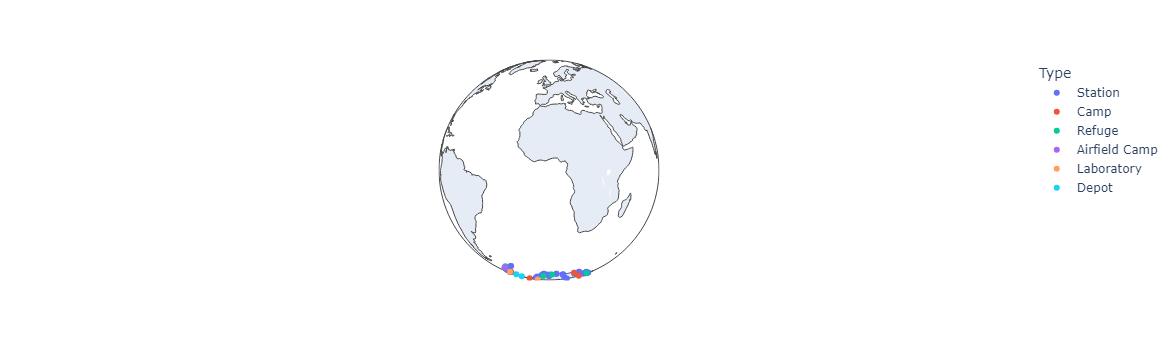

In [9]:
import plotly.express as px
fig = px.scatter_geo(comnap_df,
                    lat=comnap_df["Latitude (DD)"],
                    lon=comnap_df["Longitude (DD)"],
                    hover_name="English Name",
                    color = "Type")
fig.update_geos(projection_type="orthographic")
fig.show()

## Finalizing station table
Before we start doing coordinate transforms, let's drop stations that have NaN longitude values and aggregate entries to the extent we can. 
This next line reduces the large station table to a fairly representative set of test values - it can be commmented in for testing purposes, or out to create the full table.

In [10]:
# stations = stations.loc[['PG0', 'PG1', 'PG2', 'PG3', 'PG4', 'PG5', 'Vernadsky', 'South Pole Station', 'Syowa', 'Palmer', 'McMurdo', 'Cape Disappointment', 'South Pole Station', 'Bor', 'Clyde River']]
stations

ID       Category Network         Nation  \
Name                                                                 
Nain                     NAN  Magnetometers   MACCS            USA   
Pangnirtung              PGG  Magnetometers   MACCS            USA   
Clyde River              CRV  Magnetometers   MACCS            USA   
Iqaluit                  IQA  Magnetometers   MACCS         Canada   
Cape Dorset              CDR  Magnetometers   MACCS            USA   
...                      ...            ...     ...            ...   
Shackleton Glacier Camp  NaN           Camp     NaN  United States   
Siple Dome               NaN           Camp     NaN  United States   
WAIS Divide              NaN           Camp     NaN  United States   
Artigas                  NaN        Station     NaN        Uruguay   
Ruperto Elichiribehety   NaN        Station     NaN        Uruguay   

                              Institution       GLAT        GLON Start End  \
Name                                                                         
Nain                     Augsburg College       56.4       298.3   NaT NaT   
Pangnirtung              Augsburg College       66.1       294.2   NaT NaT   
Clyde River              Augsburg College       70.5       291.4   NaT NaT   
Iqaluit                  Augsburg College       63.8       291.5   NaT NaT   
Cape Dorset              Augsburg College       64.2       283.4   NaT NaT   
...                                   ...        ...         ...   ...  ..   
Shackleton Glacier Camp               NaN -85.086232 -175.289469   NaT NaT   
Siple Dome                            NaN -81.653771 -149.001846   NaT NaT   
WAIS Divide                           NaN -79.471286 -112.072154   NaT NaT   
Artigas                               NaN -62.184551  -58.902442   NaT NaT   
Ruperto Elichiribehety                NaN -63.402372  -56.990907   NaT NaT   

                         Notes  ...          Antarctic Region  Latitude (DDM)  \
Name                            ...                                             
Nain                       NaN  ...                       NaN             NaN   
Pangnirtung                NaN  ...                       NaN             NaN   
Clyde River                NaN  ...                       NaN             NaN   
Iqaluit                    NaN  ...                       NaN             NaN   
Cape Dorset                NaN  ...                       NaN             NaN   
...                        ...  ...                       ...             ...   
Shackleton Glacier Camp    NaN  ...  Transantarctic Mountains   85° 5.1739' S   
Siple Dome                 NaN  ...           West Antarctica  81° 39.2263' S   
WAIS Divide                NaN  ...           West Antarctica  79° 28.2772' S   
Artigas                    NaN  ...                       NaN  62° 11.0731' S   
Ruperto Elichiribehety     NaN  ...                       NaN  63° 24.1423' S   

                         Longitude (DDM) Elevation (meters) Elevation Datum  \
Name                                                                          
Nain                                 NaN                NaN             NaN   
Pangnirtung                          NaN                NaN             NaN   
Clyde River                          NaN                NaN             NaN   
Iqaluit                              NaN                NaN             NaN   
Cape Dorset                          NaN                NaN             NaN   
...                                  ...                ...             ...   
Shackleton Glacier Camp  175° 17.3681' W                NaN             NaN   
Siple Dome                149° 0.1108' W                NaN             NaN   
WAIS Divide               112° 4.3292' W                NaN             NaN   
Artigas                   58° 54.1465' W               17.0             MSL   
Ruperto Elichiribehety    56° 59.4544' W               28.0             MSL   

                  

In [11]:
# Testing conjcalc() with just lat and lon data....

df2 = stations[['GLAT', 'GLON']].copy()
# conjcalc(df2)
# print(df2)
conjcalc(df2)

Ran into a problem with Nain
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Pangnirtung
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Clyde River
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Iqaluit
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Cape Dorset
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Igloolik
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Coral Harbour
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Repulse Bay
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Baker Lake
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Gjoa Haven
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Resolute Bay
'>' not supported between instances of 'str' and 'int'
Ran into a p

GLAT        GLON Hemisphere       PLAT  \
Name                                                                   
Nain                          56.4       298.3          N  56.400000   
Pangnirtung                   66.1       294.2          N  66.100000   
Clyde River                   70.5       291.4          N  70.500000   
Iqaluit                       63.8       291.5          N  63.750000   
Cape Dorset                   64.2       283.4          N  64.200000   
...                            ...         ...        ...        ...   
Shackleton Glacier Camp -85.086232 -175.289469          S  29.996267   
Siple Dome              -81.653771 -149.001846          S  64.393546   
WAIS Divide             -79.471286 -112.072154          S  58.925280   
Artigas                 -62.184551  -58.902442          S  42.625352   
Ruperto Elichiribehety  -63.402372  -56.990907          S  44.015575   

                               PLON  
Name                                 
Nain                     -61.700000  
Pangnirtung              -65.800000  
Clyde River              -68.600000  
Iqaluit                  -68.520000  
Cape Dorset              -76.600000  
...                             ...  
Shackleton Glacier Camp  290.519847  
Siple Dome               277.451290  
WAIS Divide              279.867821  
Artigas                  290.601369  
Ruperto Elichiribehety   291.474200  

[1021 rows x 5 columns]

### Eclipse Paths
Shunrong Zhang computed paths at various elevations for relevant eclipses. These can be found in the `/input` file.

Code to convert all the eclipse paths to .gpx files (only needed to run this once).

In [12]:
# # import required module
# import os
# # assign directory
# directory = 'input'


# os.listdir(directory)
# # iterate over files in
# # that directory
# for filename in os.listdir(directory):
#     try:
#         f = os.path.join(directory, filename)
#         header = ["YEAR/M/DD", "HH:MM:SS",  "UTC", "MIN Magni", "LAT", "LONG"] #Min Magni = minimum obscuration magnitude (ratio), based on the fraction of the visible solar disk area screened by the Moon
#         eclipse = pd.read_csv(f, sep='\s+', names = header)
#         df = eclipse[['LAT', 'LONG']]
#         gpx = gpxpy.gpx.GPX()

#         # Create first track in our GPX:
#         gpx_track = gpxpy.gpx.GPXTrack()
#         gpx.tracks.append(gpx_track)

#         # Create first segment in our GPX track:
#         gpx_segment = gpxpy.gpx.GPXTrackSegment()
#         gpx_track.segments.append(gpx_segment)

#         # Create points:
#         for idx in df.index:
#             gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(df.loc[idx, 'LAT'], df.loc[idx, 'LONG']))

#         # print(gpx.to_xml())

#         with open('output/'+filename+'.gpx', 'w') as f:
#             f.write(gpx.to_xml())
#         print('Writing ' + filename + " to gpx. ")
#     except Exception as e:
#         print(e)
#         continue
    

### Satellite Paths
- [ ] GOES East

## Maps

### Global Map
- [x] Let's begin by plotting all the points on a globe map using plotly express.

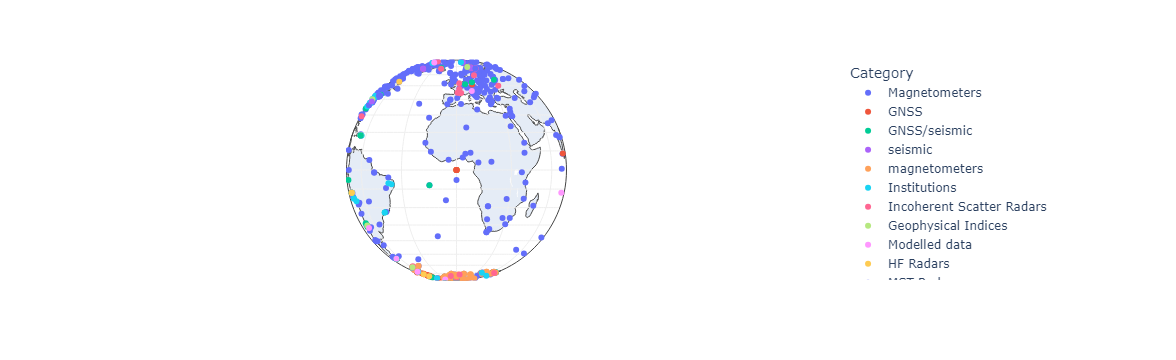

In [13]:
fig = px.scatter_geo(stations.reset_index(),
                    lat=stations["GLAT"],
                    lon=stations["GLON"],
                    hover_name="Name",
                    hover_data=["Category"],
                    color = "Category")
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.show()
fig.write_html("output/all-stations.html")

### Antarctic Coastline
- [X] Pull data from https://geodata.lib.berkeley.edu/catalog/stanford-yk702xd7587
- [ ] Map the data with plotly express or similar
- [ ] Convert the coordinates to geomagnetic coordinates and plot them

We can visualize the geometry of the coastline directly in Jupyter notebook. Yep, looks like Antarctica:

Let's compute the conjugate points for this outline, then export them as a .gpx file. That shape is *huge*, so let's  reduce the resolution so it's easier to run computations on.

### Coordinate Conversions
- [X] Create/find a function to convert geographic to geomagnetic coordinates. Might try https://pypi.org/project/aacgmv2/ or https://github.com/space-physics/geo2mag
- [X] Add a column with the conjugate geomagnetic coordinates
- [X] Add a column with the conjugate geomagnetic coordinates converted back into geographic coordinates
- [X] Map the geographic coordinates of the Northern Hemisphere stations and the conjugate geographic coordinates of the Southern Hemisphere stations

In [14]:
# stations['GLON'] = stations['GLON'].astype(float)

In [15]:
stations
conjcalc(stations)

Ran into a problem with Nain
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Pangnirtung
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Clyde River
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Iqaluit
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Cape Dorset
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Igloolik
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Coral Harbour
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Repulse Bay
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Baker Lake
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Gjoa Haven
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Resolute Bay
'>' not supported between instances of 'str' and 'int'
Ran into a p

ID       Category Network         Nation  \
Name                                                                 
Nain                     NAN  Magnetometers   MACCS            USA   
Pangnirtung              PGG  Magnetometers   MACCS            USA   
Clyde River              CRV  Magnetometers   MACCS            USA   
Iqaluit                  IQA  Magnetometers   MACCS         Canada   
Cape Dorset              CDR  Magnetometers   MACCS            USA   
...                      ...            ...     ...            ...   
Shackleton Glacier Camp  NaN           Camp     NaN  United States   
Siple Dome               NaN           Camp     NaN  United States   
WAIS Divide              NaN           Camp     NaN  United States   
Artigas                  NaN        Station     NaN        Uruguay   
Ruperto Elichiribehety   NaN        Station     NaN        Uruguay   

                              Institution       GLAT        GLON Start End  \
Name                                                                         
Nain                     Augsburg College       56.4       298.3   NaT NaT   
Pangnirtung              Augsburg College       66.1       294.2   NaT NaT   
Clyde River              Augsburg College       70.5       291.4   NaT NaT   
Iqaluit                  Augsburg College       63.8       291.5   NaT NaT   
Cape Dorset              Augsburg College       64.2       283.4   NaT NaT   
...                                   ...        ...         ...   ...  ..   
Shackleton Glacier Camp               NaN -85.086232 -175.289469   NaT NaT   
Siple Dome                            NaN -81.653771 -149.001846   NaT NaT   
WAIS Divide                           NaN -79.471286 -112.072154   NaT NaT   
Artigas                               NaN -62.184551  -58.902442   NaT NaT   
Ruperto Elichiribehety                NaN -63.402372  -56.990907   NaT NaT   

                         Notes  ... Elevation (meters) Elevation Datum  \
Name                            ...                                      
Nain                       NaN  ...                NaN             NaN   
Pangnirtung                NaN  ...                NaN             NaN   
Clyde River                NaN  ...                NaN             NaN   
Iqaluit                    NaN  ...                NaN             NaN   
Cape Dorset                NaN  ...                NaN             NaN   
...                        ...  ...                ...             ...   
Shackleton Glacier Camp    NaN  ...                NaN             NaN   
Siple Dome                 NaN  ...                NaN             NaN   
WAIS Divide                NaN  ...                NaN             NaN   
Artigas                    NaN  ...               17.0             MSL   
Ruperto Elichiribehety     NaN  ...               28.0             MSL   

                         Peak Population Power Supply Types  \
Name                                                          
Nain                                 NaN                NaN   
Pangnirtung                          NaN                NaN   
Clyde River                          NaN                NaN   
Iqaluit                              NaN                NaN   
Cape Dorset                          NaN                NaN   
...                                  ...                ...   
Shackleton Glacier Camp             20.0                NaN   
Siple Dome                          10.0                NaN   
WAIS Divide                         40.0                NaN   
Artigas                             50.0        Fossil Fuel   
Ruperto Elichiribehety               8.0        Fossil Fuel   

                                                                 Photo URL  \
Name                                                                         
Nain                                                                   NaN   
Pangnirtung                                                            NaN   
Clyde

In [16]:
stations.loc['Vernadsky']
stations.loc['South Pole Station']

ID                                  SPA
Category                  Magnetometers
Network                         PENGUIN
Nation                              NaN
Institution                         NaN
GLAT                              -90.0
GLON                                0.0
Start                               NaT
End                                 NaT
Notes                               NaN
Data Link                           NaN
Source                         SuperMAG
Instrument id (kinst)               NaN
Altitude (km)                       NaN
Principal Investigator              NaN
PI Email                            NaN
AACGMLON                          19.01
AACGMLAT                         -74.08
OPERATOR-NUM                        1.0
OP2                                 NaN
OP3                                 NaN
Unnamed: 10                         NaN
Unnamed: 11                         NaN
Record ID#                          NaN
Official Name                       NaN


In [17]:
# stations.groupby(['Name']).agg(lambda col: ','.join(col)) # aggregate rows...

In [18]:
# stations = conjcalc(stations)
conjcalc(stations)

Ran into a problem with Nain
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Pangnirtung
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Clyde River
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Iqaluit
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Cape Dorset
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Igloolik
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Coral Harbour
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Repulse Bay
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Baker Lake
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Gjoa Haven
'>' not supported between instances of 'str' and 'int'
Ran into a problem with Resolute Bay
'>' not supported between instances of 'str' and 'int'
Ran into a p

ID       Category Network         Nation  \
Name                                                                 
Nain                     NAN  Magnetometers   MACCS            USA   
Pangnirtung              PGG  Magnetometers   MACCS            USA   
Clyde River              CRV  Magnetometers   MACCS            USA   
Iqaluit                  IQA  Magnetometers   MACCS         Canada   
Cape Dorset              CDR  Magnetometers   MACCS            USA   
...                      ...            ...     ...            ...   
Shackleton Glacier Camp  NaN           Camp     NaN  United States   
Siple Dome               NaN           Camp     NaN  United States   
WAIS Divide              NaN           Camp     NaN  United States   
Artigas                  NaN        Station     NaN        Uruguay   
Ruperto Elichiribehety   NaN        Station     NaN        Uruguay   

                              Institution       GLAT        GLON Start End  \
Name                                                                         
Nain                     Augsburg College       56.4       298.3   NaT NaT   
Pangnirtung              Augsburg College       66.1       294.2   NaT NaT   
Clyde River              Augsburg College       70.5       291.4   NaT NaT   
Iqaluit                  Augsburg College       63.8       291.5   NaT NaT   
Cape Dorset              Augsburg College       64.2       283.4   NaT NaT   
...                                   ...        ...         ...   ...  ..   
Shackleton Glacier Camp               NaN -85.086232 -175.289469   NaT NaT   
Siple Dome                            NaN -81.653771 -149.001846   NaT NaT   
WAIS Divide                           NaN -79.471286 -112.072154   NaT NaT   
Artigas                               NaN -62.184551  -58.902442   NaT NaT   
Ruperto Elichiribehety                NaN -63.402372  -56.990907   NaT NaT   

                         Notes  ... Elevation (meters) Elevation Datum  \
Name                            ...                                      
Nain                       NaN  ...                NaN             NaN   
Pangnirtung                NaN  ...                NaN             NaN   
Clyde River                NaN  ...                NaN             NaN   
Iqaluit                    NaN  ...                NaN             NaN   
Cape Dorset                NaN  ...                NaN             NaN   
...                        ...  ...                ...             ...   
Shackleton Glacier Camp    NaN  ...                NaN             NaN   
Siple Dome                 NaN  ...                NaN             NaN   
WAIS Divide                NaN  ...                NaN             NaN   
Artigas                    NaN  ...               17.0             MSL   
Ruperto Elichiribehety     NaN  ...               28.0             MSL   

                         Peak Population Power Supply Types  \
Name                                                          
Nain                                 NaN                NaN   
Pangnirtung                          NaN                NaN   
Clyde River                          NaN                NaN   
Iqaluit                              NaN                NaN   
Cape Dorset                          NaN                NaN   
...                                  ...                ...   
Shackleton Glacier Camp             20.0                NaN   
Siple Dome                          10.0                NaN   
WAIS Divide                         40.0                NaN   
Artigas                             50.0        Fossil Fuel   
Ruperto Elichiribehety               8.0        Fossil Fuel   

                                                                 Photo URL  \
Name                                                                         
Nain                                                                   NaN   
Pangnirtung                                                            NaN   
Clyde

In [19]:
stations[stations.index=="PG0"].GLON

Name
PG0    88.68
PG0    88.68
Name: GLON, dtype: object

Now to save it as a .gpx file (Run `pip install gpxpy` if you don't have it installed already) and a .CSV:

In [20]:
stations.to_csv('output/stations.csv') #save as .csv

And map:

In [21]:
stations

ID       Category Network         Nation  \
Name                                                                 
Nain                     NAN  Magnetometers   MACCS            USA   
Pangnirtung              PGG  Magnetometers   MACCS            USA   
Clyde River              CRV  Magnetometers   MACCS            USA   
Iqaluit                  IQA  Magnetometers   MACCS         Canada   
Cape Dorset              CDR  Magnetometers   MACCS            USA   
...                      ...            ...     ...            ...   
Shackleton Glacier Camp  NaN           Camp     NaN  United States   
Siple Dome               NaN           Camp     NaN  United States   
WAIS Divide              NaN           Camp     NaN  United States   
Artigas                  NaN        Station     NaN        Uruguay   
Ruperto Elichiribehety   NaN        Station     NaN        Uruguay   

                              Institution       GLAT        GLON Start End  \
Name                                                                         
Nain                     Augsburg College       56.4       298.3   NaT NaT   
Pangnirtung              Augsburg College       66.1       294.2   NaT NaT   
Clyde River              Augsburg College       70.5       291.4   NaT NaT   
Iqaluit                  Augsburg College       63.8       291.5   NaT NaT   
Cape Dorset              Augsburg College       64.2       283.4   NaT NaT   
...                                   ...        ...         ...   ...  ..   
Shackleton Glacier Camp               NaN -85.086232 -175.289469   NaT NaT   
Siple Dome                            NaN -81.653771 -149.001846   NaT NaT   
WAIS Divide                           NaN -79.471286 -112.072154   NaT NaT   
Artigas                               NaN -62.184551  -58.902442   NaT NaT   
Ruperto Elichiribehety                NaN -63.402372  -56.990907   NaT NaT   

                         Notes  ... Elevation (meters) Elevation Datum  \
Name                            ...                                      
Nain                       NaN  ...                NaN             NaN   
Pangnirtung                NaN  ...                NaN             NaN   
Clyde River                NaN  ...                NaN             NaN   
Iqaluit                    NaN  ...                NaN             NaN   
Cape Dorset                NaN  ...                NaN             NaN   
...                        ...  ...                ...             ...   
Shackleton Glacier Camp    NaN  ...                NaN             NaN   
Siple Dome                 NaN  ...                NaN             NaN   
WAIS Divide                NaN  ...                NaN             NaN   
Artigas                    NaN  ...               17.0             MSL   
Ruperto Elichiribehety     NaN  ...               28.0             MSL   

                         Peak Population Power Supply Types  \
Name                                                          
Nain                                 NaN                NaN   
Pangnirtung                          NaN                NaN   
Clyde River                          NaN                NaN   
Iqaluit                              NaN                NaN   
Cape Dorset                          NaN                NaN   
...                                  ...                ...   
Shackleton Glacier Camp             20.0                NaN   
Siple Dome                          10.0                NaN   
WAIS Divide                         40.0                NaN   
Artigas                             50.0        Fossil Fuel   
Ruperto Elichiribehety               8.0        Fossil Fuel   

                                                                 Photo URL  \
Name                                                                         
Nain                                                                   NaN   
Pangnirtung                                                            NaN   
Clyde

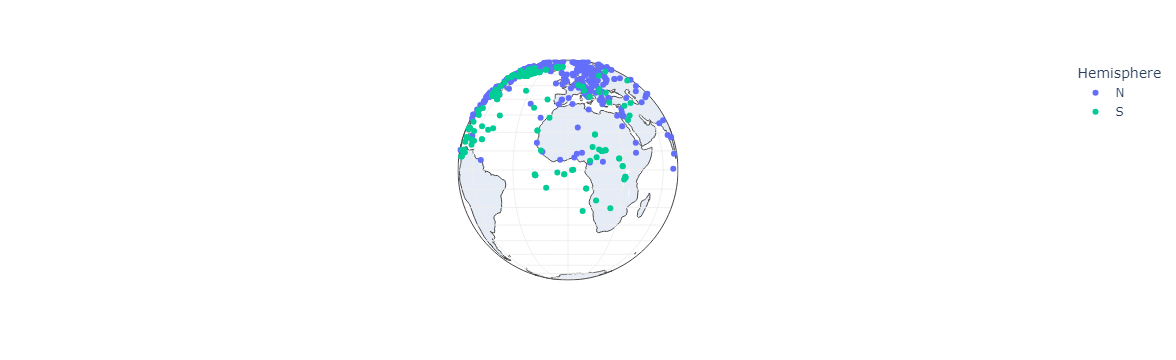

In [22]:
fig = px.scatter_geo(stations.reset_index(),
                    lat=stations["PLAT"],
                    lon=stations["PLON"],
                    hover_name="Name",
                    hover_data=["Category"],
                    color = "Hemisphere")
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.show()
fig.write_html("output/conj-stations.html")

In [23]:
fig = px.scatter_geo(stations.reset_index(),
                    lat=stations["PLAT"],
                    lon=stations["PLON"],
                    hover_name="Name",
                    hover_data=["Category"],
                    color = "Hemisphere")
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})

fig.write_html("output/conj-stations.html")

As a sanity check, let's look at just the conjugate points for southern stations, color-coded by source.

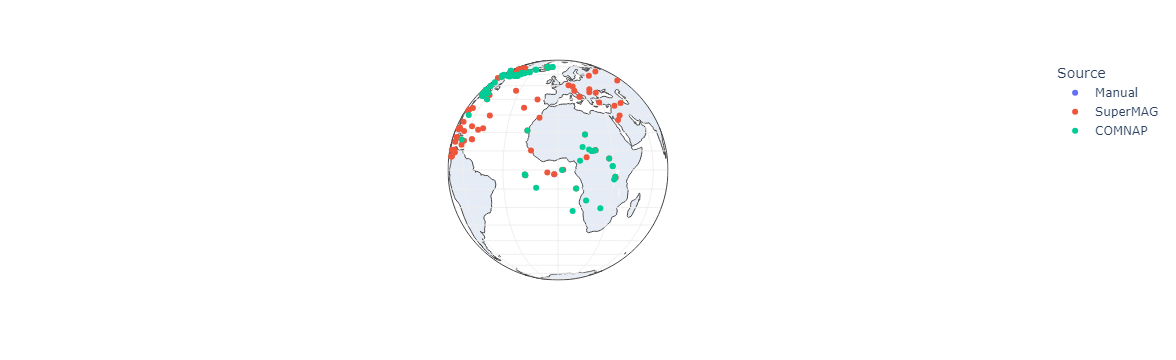

In [24]:
fig = px.scatter_geo(stations[stations['Hemisphere']=='S'].reset_index(),
                    lat=stations[stations['Hemisphere']=='S']["PLAT"],
                    lon=stations[stations['Hemisphere']=='S']["PLON"],
                    hover_name="Name",
                    # hover_data=["Hemisphere"],
                    hover_data = ["GLAT", "GLON"],
                    color = "Source")#stations["GLAT"])
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.show()
fig.write_html("output/conj-stations-south.html")

## Graticules
- [X] Figure out how to plot graticules (lat/lon lines) for both geographic coordinates.
- [ ] Figure out how to plot graticules for magnetic coordinates.

Here's a plot from Nathaniel Frissell that shows what we're going for:

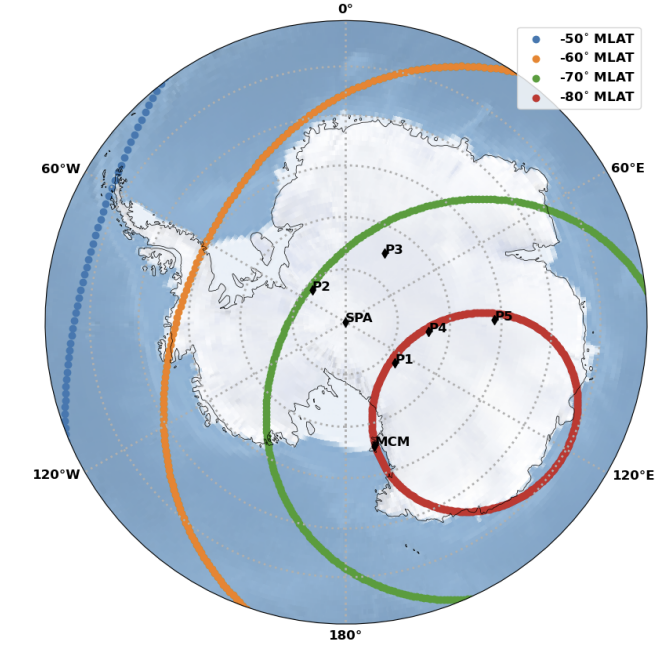

In [25]:
# gdf = geopandas.read_file(file_path)
gdf = gdf.explode(ignore_index=True)

fig = px.choropleth(
    gdf,
    geojson=gdf.geometry,
    # color='surface',
    # scope="north america",
    locations=gdf.index##['surface']
)

fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

NameError: name 'gdf' is not defined

## Citations
- Please cite this item as 'Gerrish, L., Ireland, L., Fretwell, P., & Cooper, P. (2023). High resolution vector polylines of the Antarctic coastline (7.7) [Data set]. UK Polar Data Centre, Natural Environment Research Council, UK Research & Innovation. https://doi.org/10.5285/70ac5759-34ee-4f39-9069-2116db592340'. If using for a graphic or if short on space, please cite as 'data from the SCAR Antarctic Digital Database, 2023'

- Shepherd, S. G. (2014), Altitude‐adjusted corrected geomagnetic coordinates: Definition and functional approximations, Journal of Geophysical Research: Space Physics, 119, 7501–7521, doi:10.1002/2014JA020264.

- Connors, M., Schofield, I., Reiter, K. et al. The AUTUMNX magnetometer meridian chain in Québec, Canada. Earth Planet Sp 68, 2 (2016). https://doi.org/10.1186/s40623-015-0354-4

- Gjerloev, J. W. (2012), The SuperMAG data processing technique, J. Geophys. Res., 117, A09213, doi:10.1029/2012JA017683.
- Gjerloev, J. W. (2009), A Global Ground-Based Magnetometer Initiative, EOS, 90, 230-231, doi:10.1029/2009EO270002.

- Acknowledgment: Eclipse paths computed by Shunrong Zhang.

- Acknowledgment: Code contributions by Rachel and Nathaniel Frissell.

- Acknowledgment: The authors used the Bard large language model from Google AI to generate some of the code used in this work.

- cite https://geodata.lib.berkeley.edu/catalog/stanford-yk702xd7587

### Other stuff to try....

- Animated plot, like the one in this example (https://rstudio-pubs-static.s3.amazonaws.com/600936_f56ee4248a3f4b5098e49ab7a56dc1ab.html), showing the movement of magnetic coordinates over time
- Satellite paths
- Magnetic graticules
- For loop to export conjugate coordinates for multiple dates and/or multiple models
- Code to identify and pull redundant stations
- visualize conjugate Antarctic outline in Jupyter notebook